In [1]:
import math
import random

import fiona
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import shapely

from descartes import PolygonPatch
from numpy.random import RandomState
from pyproj import Proj, transform
from shapely.ops import cascaded_union
from shapely.geometry import LineString, MultiPoint, MultiPolygon, Point, Polygon, shape

import delaunay_ppa
import mantel
import HSIC
import morans_i

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/dongnguyen/Programs/anaconda/envs/geoling_test/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon', 'random', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Utility methods

In [2]:
def readNLmap():
    """ Reads in the map of the Netherlands based on shapefiles"""
    # Read in the shape file and print some basic info
    shp = fiona.open('../data/shapefiles/gem_2012_v2.shp')
    #print shp.crs
    bounds = shp.bounds
    proj_nl = Proj(shp.crs) 

    # Process the polygons from the shapefile
    polygons = []
    polygon_names = {}  # <name, id>
    polygon_metadata = {} # <id, metadata>
    for entry in shp:
        # Skip polygons that are water
        if entry['properties']['WATER'] == "JA":
            continue
        p =  shapely.geometry.shape(entry['geometry'])
        polygonID = len(polygons)
        polygon_names[entry['properties']['GM_NAAM']] = polygonID
        polygon_metadata[polygonID] = {'population':max(0,entry['properties']['AANT_INW']), 
                                       'tweet_freq':0,
                                       'name':entry['properties']['GM_NAAM'],
                                       'official_ID':entry['properties']['GM_CODE']}
        polygons.append(p)

    shp.close()  

    polygons = np.asarray(polygons)
    return polygons, polygon_names, bounds, polygon_metadata, proj_nl

In [3]:
def plotMapFrequencyPoints(polygons, locs, frequencies, axes_limits=None, 
                          figsize=(10,10), axis_off=False, locs_centers=None):
    """
    Plots the map
    polygons: an array of polygon objects.
    locs: locations of the messages. 
    frequencies: frequencies that represent each location.
    axes_limits: the limit of the axes of the plot.
    """
    colors = ["#fef0d9",
            "#fdcc8a",
            "#fc8d59",
            "#e34a33",
            "#b30000"]
        
    edge_color = "#f0f0f0"
    fig = plt.figure(1, figsize=figsize, dpi=90)
    ax = fig.add_subplot(111)     

    # Add polygons, and color them if we have frequency data
    for id, p in enumerate(polygons):
        color = "#CACACB"
                    
        if p.geom_type == 'Polygon':
            ax.add_patch(
                PolygonPatch(p, fc=color, ec=color))
        else:
            for p2 in p:
                ax.add_patch(
                    PolygonPatch(p2, fc=color, ec=color))           


    bins =  np.array([int(t) for t in 5 * scipy.stats.rankdata(frequencies, "average")/len(frequencies)])
    bins[bins==5] = 4
    
    for i, bin_color in enumerate(colors): 
        ax.scatter(locs[bins==i,0],locs[bins==i,1], color=bin_color, s=25, alpha=1, zorder=100, edgecolors="#999999")
    
    x_min, x_max, y_min, y_max = axes_limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
        
    if locs_centers:
        for center in locs_centers:
            plt.plot(center[0], center[1], '+', mew=10, ms=20)    
        
    if axis_off:
        plt.axis('off')


In [4]:
def plotMap(polygons, locs=None, has_word=None, freq_map=None, axes_limits=None, 
            counts=None, figsize=(10,10), edge_color = "#2b2f2c", axis_off=False):
    """
    Plots the map
    polygons: an array of polygon objects.
    locs: locations of the messages. If given, will be shown as a scatter plot.
    freq_map: frequencies for the polygons.
    axes_limits: the limit of the axes of the plot.
    """

    colors = ["#67001f",
            "#b2182b",
            "#d6604d",
            "#f4a582", #
            "#fddbc7", #
            "#d1e5f0", #
            "#92c5de", #
            "#4393c3",
            "#2166ac",
            "#053061"]
    
    boundaries = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
        
    fig = plt.figure(1, figsize=figsize, dpi=90)
    ax = fig.add_subplot(111)
    
    # Add scatter plot in case we have location data
    if np.any(locs):
        if sum(has_word==0) > 0:
            ax.scatter(locs[has_word==0,0],locs[has_word==0,1], s=50, zorder=100, marker="^", label=scatterplot_labels[0])
        if sum(has_word==1) > 0:
            ax.scatter(locs[has_word==1,0],locs[has_word==1,1],color='r', s=50, zorder=99, marker='s', label=scatterplot_labels[1])
        if sum(has_word==2) > 0:
            ax.scatter(locs[has_word==2,0],locs[has_word==2,1],color='g', s=50, zorder=100, marker="*", label=scatterplot_labels[2])
        if sum(has_word==3) > 0:
            ax.scatter(locs[has_word==3,0],locs[has_word==3,1],color='m', s=50, zorder=100, marker="D", label=scatterplot_labels[3])
        if sum(has_word==4) > 0:
            ax.scatter(locs[has_word==4,0],locs[has_word==4,1],color='y', s=50, zorder=100, marker="+", label=scatterplot_labels[4])
        
        plt.legend(
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=18, #23
           frameon=False)

        
    patches = []
    patches_colors = []
    # Add polygons, and color them if we have frequency data
    for id, p in enumerate(polygons):
        color = "#CACACB"
        
        # if number of observations in polygon is zero, color grey
        if np.any(counts) and counts[id] == 0:
            color = "#CACACB"
        elif np.any(freq_map): #elif
            color = colors[-1]
            freq =  freq_map[id]
            for i, min_val in enumerate(boundaries):
                if freq >= min_val:
                    color = colors[i]
                    break
                    
        polygon_alpha = 0.8
       
        if p.geom_type == 'Polygon':
            pp = PolygonPatch(p, fc=color, ec=edge_color, alpha=polygon_alpha)
            ax.add_patch(pp)
            
            patches.append(pp)
            patches_colors.append(color)
        else:
            for p2 in p:
                pp = PolygonPatch(p2, fc=color, ec=edge_color, alpha=polygon_alpha)
                ax.add_patch(pp)  
                patches.append(pp)
                patches_colors.append(color)
                
    x_min, x_max, y_min, y_max = axes_limits
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    if axis_off:
        plt.axis('off')
        

# Synthetic data

First read in the map of the Netherlands

In [5]:
# Read in the map
polygons_nl, polygons_nl_names, nl_bounds, polygons_nl_metadata, proj_nl = readNLmap()

# Calculate a distance matrix based on municipalities in the Netherlands
distance_matrix_nl = morans_i.getDistanceMatrixPolygons(polygons_nl)

# Turn this into a weight matrix based on a distance treshold
MEDIAN_DISTANCE_MUNI = 99335
weights = morans_i.getWeightMatrix(distance_matrix_nl, MEDIAN_DISTANCE_MUNI)

# The number of permutations used to calculate p-values
N_SAMP=500


## Frequency data

We first read in the data from a file called 0-0-0.npz. The file is named according to [sigma-angle-i], 
meaning a variance of 0, an angle of 0 (thus a dialect continuum from east to west, and the first run (0).

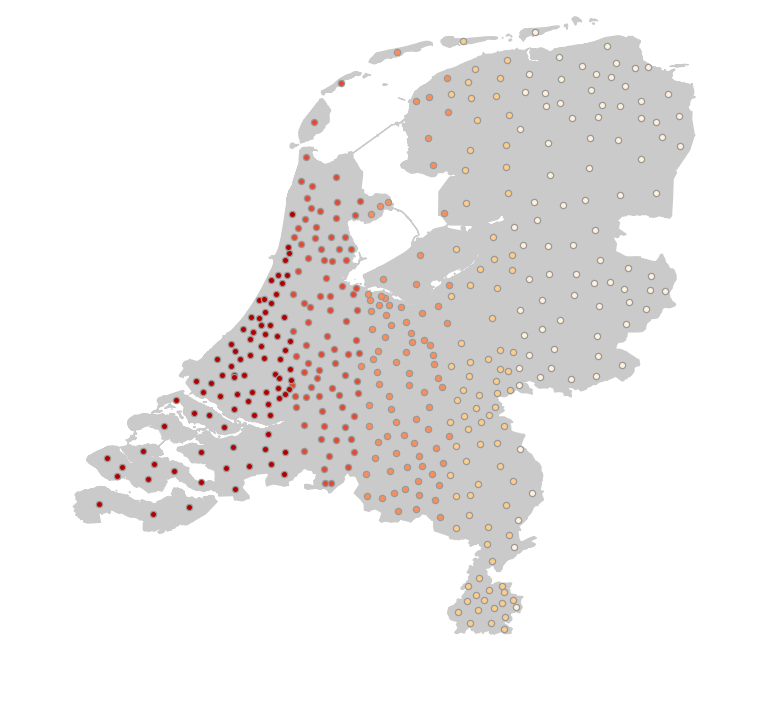

In [6]:
# Load and plot the map
data =  np.load('../data/synthetic_experiments/freq_angles_sigma/0-0-0.npz')

plotMapFrequencyPoints(polygons_nl, data['locs'], data['freq'], axes_limits = nl_bounds, axis_off=True)

The following data contains a dialect continuum in a 90 degrees angle.

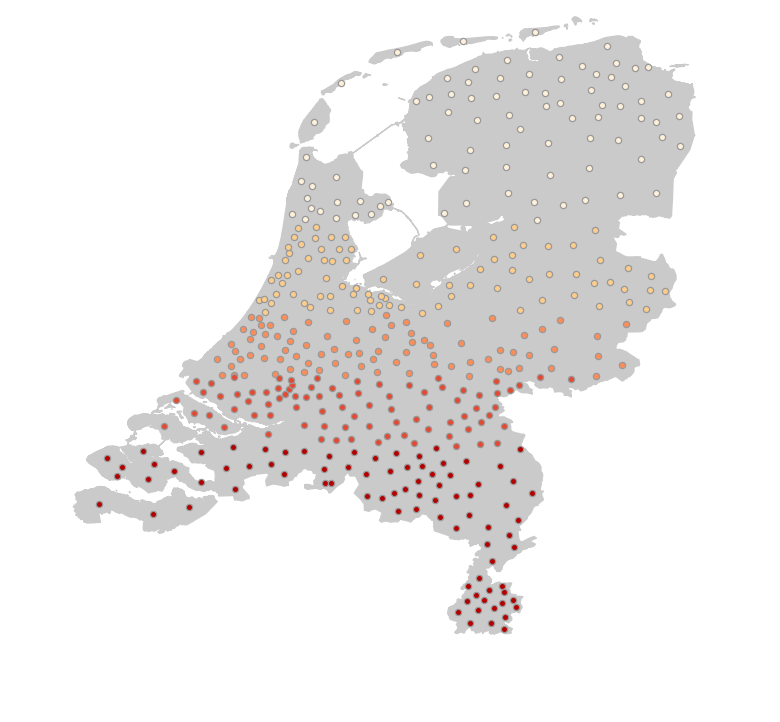

In [7]:
data =  np.load('../data/synthetic_experiments/freq_angles_sigma/0-90-0.npz')

plotMapFrequencyPoints(polygons_nl, data['locs'], data['freq'], axes_limits = nl_bounds, axis_off=True)

Now we apply the methods on this data. These results corresponds to numbers in ../data/synthetic_experiments/freq_angles_sigma/results.txt (row 32)

In [8]:
# Expected 0.84292
print("Mantel: %.5f (p-value: %.3f)" % mantel.mantel_pval(data['locs'], data['has_word'], 
                                                      kX="Euclidian", kY="AbsDiffFreq", N_samp=N_SAMP)) 
# Expected: 0.05848
print("HSIC: %.5f (p-value: %.3f)" % HSIC.HSIC_pval(data['locs'], data['has_word'], 
                                                kernelX="Gaussian", kernelY="Gaussian", N_samp=N_SAMP))
# Expected: 0.38761
print("Moran's I: %.5f (p-value: %.3f)" % morans_i.morans_I_pval_boots(data['freq'], weights, N_samp=N_SAMP)) 


Mantel: 0.84292 (p-value: 0.002)
HSIC: 0.05848 (p-value: 0.002)
Moran's I: 0.38761 (p-value: 0.002)


Another dataset. These results corresponds to numbers in ../data/synthetic_experiments/freq_angles_sigma/results.txt (row 696)

In [9]:
data =  np.load('../data/synthetic_experiments/freq_angles_sigma/0.125-282-0.npz')

# Expected: 0.09828
print("Mantel: %.5f (p-value: %.3f)" % mantel.mantel_pval(data['locs'], data['has_word'], 
                                                      kX="Euclidian", kY="AbsDiffFreq", N_samp=N_SAMP))
# Expected: 0.00653
print("HSIC: %.5f (p-value: %.3f)" % HSIC.HSIC_pval(data['locs'], data['has_word'], 
                                                kernelX="Gaussian", kernelY="Gaussian", N_samp=N_SAMP))
# Expected: 0.06626
print("Moran's I: %.5f (p-value: %.3f)" % morans_i.morans_I_pval_boots(data['freq'], weights, N_samp=N_SAMP)) 


Mantel: 0.09828 (p-value: 0.002)
HSIC: 0.00653 (p-value: 0.002)
Moran's I: 0.06626 (p-value: 0.002)


# Binary data

Now we load some binary data. The file format in this directory is [observations param - angle - i].
Thus, we now look at data with a 0 angle (east to west)

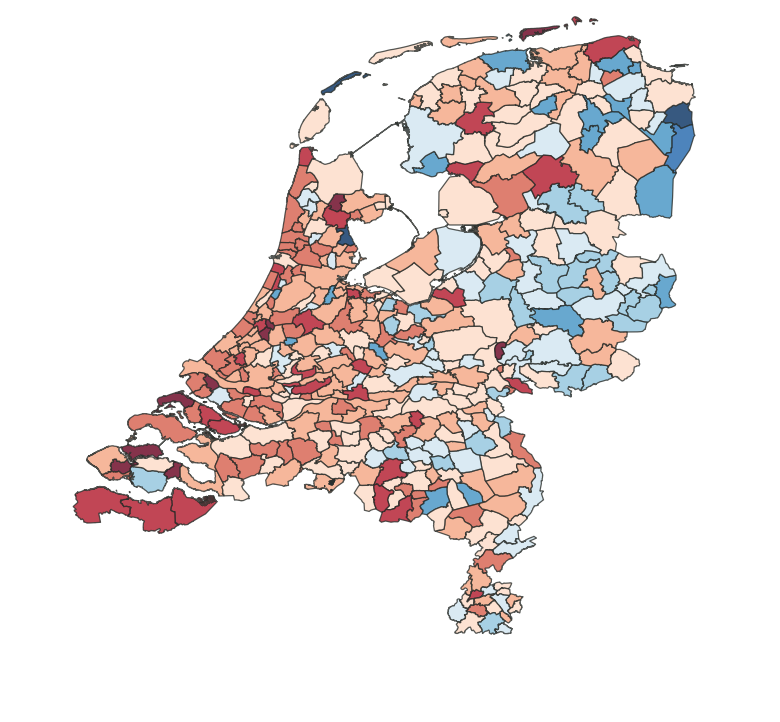

In [10]:
data =  np.load('../data/synthetic_experiments/2cat_angles_obs/0.0005-0-0.npz')

plotMap(polygons_nl, freq_map = data['freq'], axes_limits = nl_bounds, axis_off=True)

Some more data.. (90 degrees angle). Shoulds correspond to results in ../data/synthetic_experiments/2cat_angles_obs/.results.txt

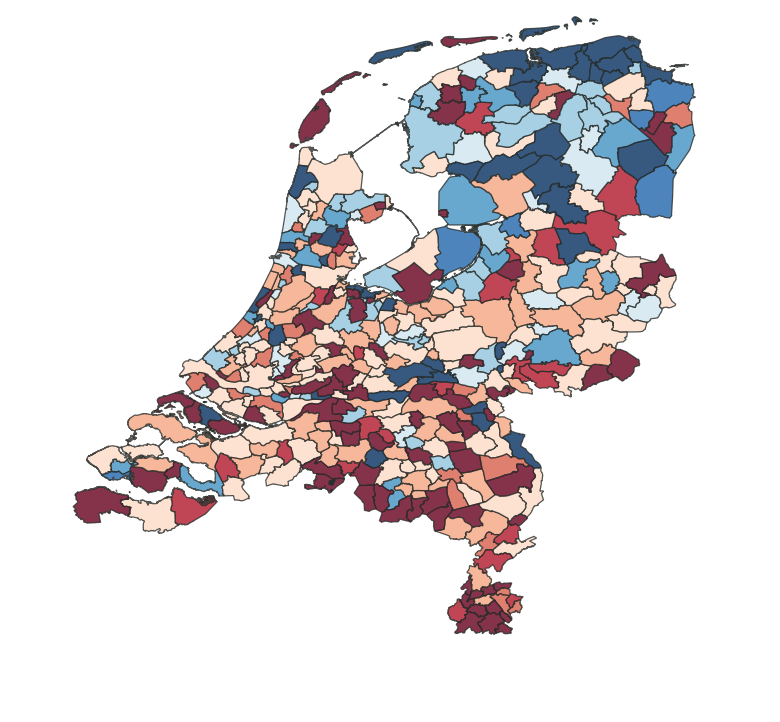

In [11]:
data =  np.load('../data/synthetic_experiments/2cat_angles_obs/0.0001-90-0.npz')
plotMap(polygons_nl, freq_map = data['freq'], axes_limits = nl_bounds, axis_off=True)

In [12]:
# Compare them with ../data/synthetic_experiments/2cat_angles_obs/results.txt (line 512)
# Expected: 0.02471
print("Mantel: %.5f (p-value: %.3f)" %mantel.mantel_pval(data['locs'], data['has_word'], 
                         kX="Euclidian", kY="Delta", N_samp=N_SAMP)) 

# Expected: 0.00241
print("HSIC: %.5f (p-value: %.3f)" %HSIC.HSIC_pval(data['locs'], data['has_word'], 
                     kernelX="Gaussian", kernelY="Delta", N_samp=N_SAMP, p_method="boots")) 

y = data['has_word'].flatten()
ymat = np.zeros((len(y),max(y)+1))
ymat[np.arange(len(y)),y] = 1

# Only p-value is printed, should not be significant.
print("Join counts p-value: %.3f" %delaunay_ppa.ppa(data['locs'], ymat, bootstrap_N=N_SAMP)[0])

# Expected: 0.05084
print("Moran's I: %.5f (p-value: %.3f)" %morans_i.morans_I_pval_boots(data['freq'], weights, N_samp=N_SAMP)) 



Mantel: 0.02471 (p-value: 0.002)
HSIC: 0.00241 (p-value: 0.002)
Join counts p-value: 0.174
Moran's I: 0.05084 (p-value: 0.002)


Some more data.. (45 degrees angle). 

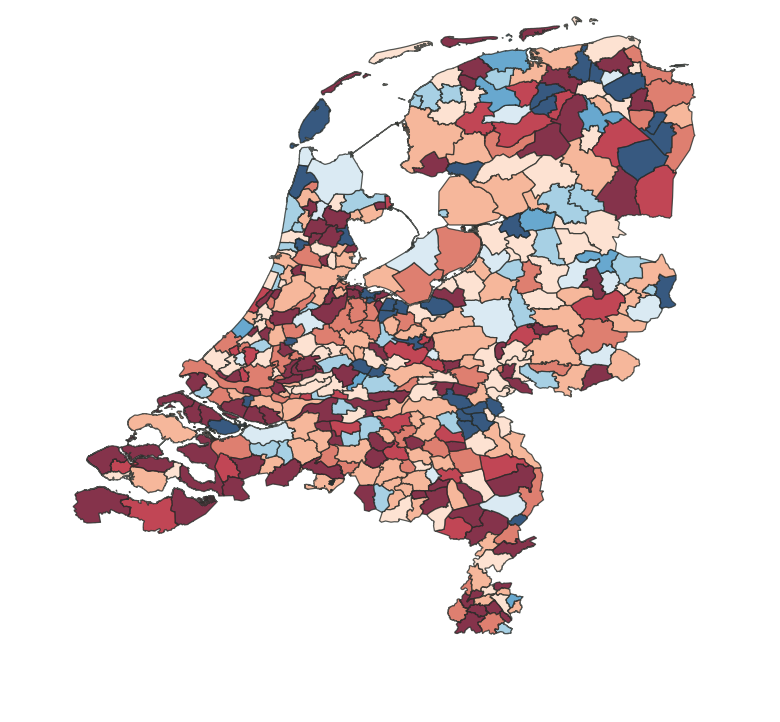

In [13]:
data =  np.load('../data/synthetic_experiments/2cat_angles_obs/0.0001-45-0.npz')

plotMap(polygons_nl, freq_map = data['freq'], axes_limits = nl_bounds, axis_off=True)

In [15]:
# Compare them with ../data/synthetic_experiments/2cat_angles_obs/results.txt (line 497)
# Expected: 0.01516
print("Mantel: %.5f (p-value: %.3f)" %mantel.mantel_pval(data['locs'], data['has_word'], 
                         kX="Euclidian", kY="Delta", N_samp=N_SAMP)) 

# Expected: 0.00106
print("HSIC: %.5f (p-value: %.3f)" %HSIC.HSIC_pval(data['locs'], data['has_word'], 
                     kernelX="Gaussian", kernelY="Delta", N_samp=N_SAMP, p_method="boots")) 

y = data['has_word'].flatten()
ymat = np.zeros((len(y),max(y)+1))
ymat[np.arange(len(y)),y] = 1

# Only p-value is printed, should not be significant.
print("Join counts p-value: %.3f" %delaunay_ppa.ppa(data['locs'], ymat, bootstrap_N=N_SAMP)[0])

# Expected: 0.02067
print("Moran's I: %.5f (p-value: %.3f)" %morans_i.morans_I_pval_boots(data['freq'], weights, N_samp=N_SAMP)) 


Mantel: 0.01516 (p-value: 0.006)
HSIC: 0.00106 (p-value: 0.002)
Join counts p-value: 0.130
Moran's I: 0.02067 (p-value: 0.002)


# Categorical data

In [16]:
data =  np.load('../data/synthetic_experiments/multi_angles_obs/5e-05-291-0.npz')


In [20]:
# Should match results in ../data/synthetic_experiments/multi_angles_obs/results.txt (line 339)
# Expected: 0.00547
print("Mantel: %.5f (p-value: %.3f)" %mantel.mantel_pval(data['locs'], data['has_word'], 
                         kX="Euclidian", kY="Delta", N_samp=N_SAMP)) 

# Expected: 0.00111
print("HSIC: %.5f (p-value: %.3f)" %HSIC.HSIC_pval(data['locs'], data['has_word'], 
                     kernelX="Gaussian", kernelY="Delta", N_samp=N_SAMP, p_method="boots")) 

y = data['has_word'].flatten()
ymat = np.zeros((len(y),max(y)+1))
ymat[np.arange(len(y)),y] = 1

# Expected: not significant
print("Join counts p-value: %.3f" %delaunay_ppa.ppa(data['locs'], ymat, bootstrap_N=N_SAMP)[0])


Mantel: 0.00547 (p-value: 0.253)
HSIC: 0.00111 (p-value: 0.004)
Join counts p-value: 0.112
